In [3]:
!pip install tensorflow==1.*


ERROR: Could not find a version that satisfies the requirement tensorflow==1.* (from versions: 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.16.0rc0)
ERROR: No matching distribution found for tensorflow==1.*


In [5]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, Input, Reshape, Activation, Lambda
from tensorflow.keras.layers import LeakyReLU, BatchNormalization, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
import matplotlib.pyplot as plt

In [1]:
import tensorflow as tf

img_rows = 28
img_cols = 28
channels = 1

# Define the image shape
img_shape = (img_rows, img_cols, channels)

z_dim = 100
num_classes = 10


-1.0


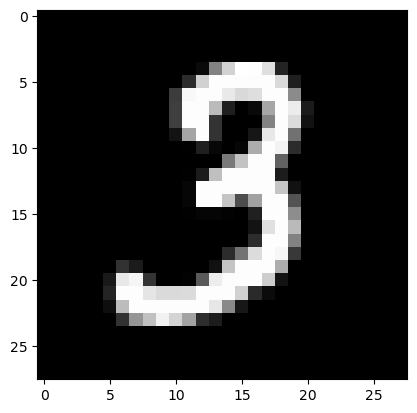

In [9]:
class Dataset:
  def __init__(self,num_labeled,num_classes):
    self.num_labeled = num_labeled
    self.num_classes = num_classes
    (self.x_train,self.y_train),(self.x_test,self.y_test) = mnist.load_data()
  
    def preprocess_image(x):
      x = (x.astype(np.float32)-127.5)/127.5
      x = np.expand_dims(x,axis=-1)
      return x
  
    def preprocess_labels(y):
      return y.reshape((-1,1))
    self.x_train = preprocess_image(self.x_train)
    print(np.min(self.x_train))
    self.y_train = preprocess_labels(self.y_train)
    self.x_test = preprocess_image(self.x_test)
    self.y_test = preprocess_labels(self.y_test)
 
  def batch_labeled(self,batch_size):
 
    sample_per_class = int(self.num_labeled/self.num_classes)
    imgs = list()
    labels = list()
    for i in range(sample_per_class):
      idx = self.y_train==i
      idx = [i for i, x in enumerate(idx) if x]
      x_classes= self.x_train[idx]
      y_classes = self.y_train[idx]
      #index = np.random.randint(0,x_classes.shape[0],sample_per_class)
      index = np.arange(sample_per_class)
      x_imgs = x_classes[index]
      y_imgs = y_classes[index]
      
      #print(x_imgs.shape)
      [imgs.append(x_imgs[j]) for j in index ]
      [labels.append(y_imgs[j]) for j in range(num_classes)]
 
    imgs = np.asarray(imgs)
    
    labels = np.asarray(labels)
    #print(labels)
 
    ix  = np.random.randint(0,self.num_labeled,batch_size)
    imgs = imgs[ix]
    labels = labels[ix]
    #print(labels.shape)
    return imgs,labels
 
  def batch_unlabeled(self,batch_size):
    idx = np.random.randint(self.num_labeled,self.x_train.shape[0],batch_size)
    imgs = self.x_train[idx]
    return imgs
 
  def training_set(self):
     x_train = self.x_train[range(self.num_labeled)]  
     y_train = self.y_train[range(self.num_labeled)]
     return x_train ,y_train
  def testing_set(self):
    return self.x_test,self.y_test
 
num_labeled = 100
num_classes = 10
dataset = Dataset(num_labeled,num_classes)
i= dataset.batch_unlabeled(32)
plt.imshow(i[0,:,:,0],cmap='gray')
#print(l[0])

In [10]:
def build_generator(z_dim):
  model = Sequential()
  model.add(Dense(256*7*7,input_dim=z_dim))
  model.add(Reshape((7,7,256)))
  model.add(Conv2DTranspose(128,kernel_size=3,strides=2,padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.01))
  model.add(Conv2DTranspose(64,kernel_size=3,strides=1,padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.01))
  model.add(Conv2DTranspose(1,kernel_size=(3,3),strides=2,padding='same',activation='tanh'))
  #model.add(Activation('tanh'))

  return model


In [11]:
def build_discriminator(img_shape):
  inp = Input(shape=img_shape)

  X = Conv2D(32,kernel_size=(3,3),strides=2,input_shape=img_shape,padding='same')(inp)
  X = LeakyReLU(alpha=0.01)(X)
  X = Conv2D(64,kernel_size=(3,3),strides=2,padding='same')(X)
  X = BatchNormalization()(X)
  X = LeakyReLU(alpha=0.01)(X)
  X = Conv2D(128,kernel_size=(3,3),strides=2,padding='same')(X)
  X = BatchNormalization()(X)
  X = LeakyReLU(alpha=0.01)(X)

  
  X = Flatten(name="flatten")(X)
  X = Dropout(0.5)(X)
  X = Dense(num_classes)(X)
  model = Model(inputs=inp,outputs=X)
  return model



In [12]:
def build_discriminator_supervised(discriminator):
  model = Sequential()
  model.add(discriminator)
  model.add(Activation('softmax'))
  return model
     

In [13]:
def build_discriminator_unsupervised(discriminator):
  model = Sequential()
  model.add(discriminator)
  def custom_activation(x):
        
    prediction = 1.0 - (1.0 /
                           (K.sum(K.exp(x), axis=-1, keepdims=True) + 1.0))
    return prediction
  model.add(Lambda(custom_activation))
  
  return model  

In [14]:
def build_gan(generator,discriminator):
  model = Sequential()
  model.add(generator)
  model.add(discriminator)
  return model

In [15]:
from tensorflow.keras import backend as K

In [17]:
def build_discriminator_unsupervised(discriminator):
  model = Sequential()
  model.add(discriminator)
  def custom_activation(x):
        
    prediction = 1.0 - (1.0 /
                           (K.sum(K.exp(x), axis=-1, keepdims=True) + 1.0))
    return prediction
  model.add(Lambda(custom_activation))
  
  return model  

In [18]:
discriminator = build_discriminator(img_shape)
discriminator_supervised = build_discriminator_supervised(discriminator)
discriminator_supervised.compile(optimizer= Adam(learning_rate=0.001),loss="categorical_crossentropy",metrics=['accuracy'])
discriminator_unsupervised = build_discriminator_unsupervised(discriminator)
discriminator_unsupervised.compile(optimizer = Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

In [19]:
generator = build_generator(z_dim)
discriminator_unsupervised.trainable = False
gan = build_gan(generator,discriminator_unsupervised)
gan.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

In [20]:
from keras.utils import to_categorical
x_test,y_test = dataset.testing_set()
y_test = to_categorical(y_test,num_classes)

In [3]:
supervised_losses = []
iteration_checkpoints = []
accuracies = []
val_losses = []
from keras.utils import to_categorical
def train(iterations,batch_size,sample_interval):

  real = np.ones((batch_size,1))
  fake = np.zeros((batch_size,1))

  for iteration in range(iterations):
    imgs,labels = dataset.batch_labeled(batch_size)
    labels = to_categorical(labels,num_classes=num_classes)
    unlabeled_imgs = dataset.batch_unlabeled(batch_size)
    z = np.random.normal(0,1,(batch_size,z_dim))
    
    fake_imgs = generator.predict(z)
    d_supervised_loss,accuracy = discriminator_supervised.train_on_batch(imgs,labels)
    d_unsupervised_loss_real = discriminator_unsupervised.train_on_batch(unlabeled_imgs,real)
    d_unsupervised_loss_fake = discriminator_unsupervised.train_on_batch(fake_imgs,fake)
    d_unsupervised_loss = 0.5*np.add(d_unsupervised_loss_real,d_unsupervised_loss_fake)

    z = np.random.normal(0,1,(batch_size,z_dim))
    fake_imgs = generator.predict(z)
    generator_loss = gan.train_on_batch(z,real)   
    if(iteration+1) % sample_interval ==0:
      supervised_losses.append(d_supervised_loss)
      accuracies.append(100*accuracy)
      iteration_checkpoints.append(iteration+1)
      val_loss = discriminator_supervised.evaluate(x=x_test,y=y_test,verbose=0)
      val_losses.append(val_loss[0])
      print("Iteration No.:",iteration+1,end=",")
      print("Discriminator Supervised Loss:",d_supervised_loss,end=',')
      print('Generator Loss:',generator_loss,end=",")
      print('Discriminator Unsuperived Loss:',d_unsupervised_loss,sep=',')
      print('val_loss:',val_loss,sep=',')
      print('Accuracy Supervised:',100*accuracy)   

In [22]:
iterations = 6000
batch_size = 32
sample_interval = 500
train(iterations,batch_size,sample_interval)

1/1 [==============================] - 6s 6s/step


1/1 [==============================] - 0s 40ms/step
Iteration No.: 500,Discriminator Supervised Loss: 0.009086021222174168,Generator Loss: [0.5323613882064819, 0.71875],Discriminator Unsuperived Loss:,[0.00407526 1.        ]
val_loss:,[1.4089184999465942, 0.6789000034332275]
Accuracy Supervised: 100.0
1/1 [==============================] - 0s 87ms/step
Iteration No.: 1000,Discriminator Supervised Loss: 0.00038824224611744285,Generator Loss: [0.011246806010603905, 1.0],Discriminator Unsuperived Loss:,[1.85910983e-04 1.00000000e+00]
val_loss:,[2.5776970386505127, 0.5835000276565552]
Accuracy Supervised: 100.0
1/1 [==============================] - 0s 42ms/step
Iteration No.: 1500,Discriminator Supervised Loss: 0.00024254016170743853,Generator Loss: [0.00112558389082551, 1.0],Discriminator Unsuperived Loss:,[1.6414393e-05 1.0000000e+00]
val_loss:,[2.2413272857666016, 0.6179999709129333]
Accuracy Supervised: 100.0
1/1 [===================

In [24]:
_,accuracy = discriminator_supervised.evaluate(x_test,y_test)
print("Test Accuracy:",accuracy)

313/313 [==============================] - 1s 4ms/step - loss: 2.5295 - accuracy: 0.6151
Test Accuracy: 0.6151000261306763


1/1 [==============================] - 0s 278ms/step


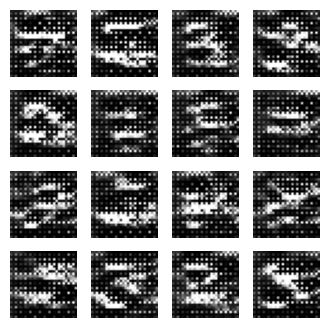

In [25]:
n_rows = 4
fig,axs = plt.subplots(n_rows,n_rows,figsize=(4,4),sharex=True,sharey=True)
z = np.random.normal(0,1,(n_rows**2,z_dim))
#z = z/2 + 0.5
gen_imgs = generator.predict(z)
gen_imgs = gen_imgs/2 + 0.5
count = 0
for i in range(n_rows):
  for j in range(n_rows):
    axs[i,j].imshow(gen_imgs[count,:,:,0],cmap='gray')
    count = count + 1
    axs[i,j].axis('off')

In [26]:
mnist_classifier = build_discriminator_supervised(
                         build_discriminator(img_shape))     

mnist_classifier.compile(loss='sparse_categorical_crossentropy',
                         metrics=['accuracy'],
                         optimizer=Adam())

In [27]:
x_train,y_train =dataset.batch_labeled(100)
mnist_classifier.fit(x=x_train,y=y_train,epochs=100)

Epoch 1/100
4/4 [==============================] - 2s 26ms/step - loss: 2.7350 - accuracy: 0.2200
Epoch 2/100
4/4 [==============================] - 0s 18ms/step - loss: 1.0763 - accuracy: 0.6500
Epoch 3/100
4/4 [==============================] - 0s 19ms/step - loss: 0.6413 - accuracy: 0.7800
Epoch 4/100
4/4 [==============================] - 0s 14ms/step - loss: 0.4257 - accuracy: 0.8700
Epoch 5/100
4/4 [==============================] - 0s 13ms/step - loss: 0.2391 - accuracy: 0.9600
Epoch 6/100
4/4 [==============================] - 0s 13ms/step - loss: 0.2472 - accuracy: 0.9300
Epoch 7/100
4/4 [==============================] - 0s 12ms/step - loss: 0.1560 - accuracy: 0.9600
Epoch 8/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0946 - accuracy: 0.9900
Epoch 9/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0884 - accuracy: 0.9900
Epoch 10/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0763 - accuracy: 1.0000
Epoch 11/100
4/4 [=

In [28]:
x,y = dataset.testing_set()
_,accuracy = mnist_classifier.evaluate(x,y)
print("Test Accuracy for fully supervised classifier:",accuracy*100)

313/313 [==============================] - 1s 4ms/step - loss: 1.0055 - accuracy: 0.6921
Test Accuracy for fully supervised classifier: 69.20999884605408
